<a href="https://colab.research.google.com/github/ziatdinovmax/GPim/blob/master/examples/notebooks/GP_sparse2Dimages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gaussian processes for sparse 2D imaging

Prepared by Maxim Ziatdinov (November 2019)

E-mail: maxim.ziatdinov@ai4microscopy.com

---

This notebook applies Gaussian process regression for reconstructing sparse 2D microscopy scans.

---



In [7]:
#@title Install/Import modules { form-width: "20%" }
# Install GPim
!python3 -m pip install -q git+https://github.com/ziatdinovmax/GPim.git --upgrade
# Imports
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from gpim import skgpr, gpr, gprutils
import torch
# download training data
!wget -qq -O 'spiral_scans_2d.npy' 'https://github.com/ziatdinovmax/GPim/blob/master/expdata/spiral_s_00010_2019.npy?raw=true'

Read and plot sparse 2D image data:

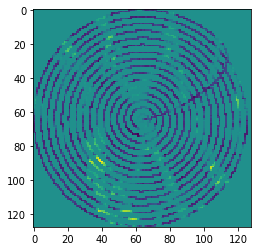

In [2]:
imgdata = np.load('spiral_scans_2d.npy')
plt.imshow(imgdata);

Normalize and assign NaNs to regions with no data:

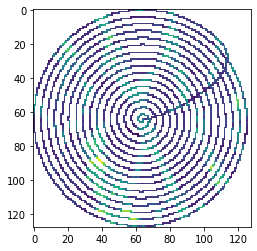

In [3]:
R = (imgdata - np.min(imgdata)) / np.ptp(imgdata)
R[R == R[1, 1]] = np.nan # Take value at [1, 1] as missing data value
plt.imshow(R);

Prepare data for GP regression. We are going to use a sparse grid ```X``` for model training and a full grid ```X_true``` for "testing"/prediction.

In [0]:
X_true = gprutils.get_full_grid(R) # get full grid indices
X = gprutils.get_sparse_grid(R) # get sparse grid indices

We will now run the GP regression for reconstructing the image from the sparse scan. Notice that by varying parameters such as ```indpoints```, ```learning_rate``` and ```iterations```, you can vary the model training time between seconds and minutes.

# of inducing points for GP regression: 1053
Model training...
average time per iteration: 0.053200000000000004 s
training completed in 15.24 s
Final parameter values:
 amp: 0.0479, lengthscale: [3.7868 2.906 ], noise: 0.0039693
Calculating predictive mean and variance... Done


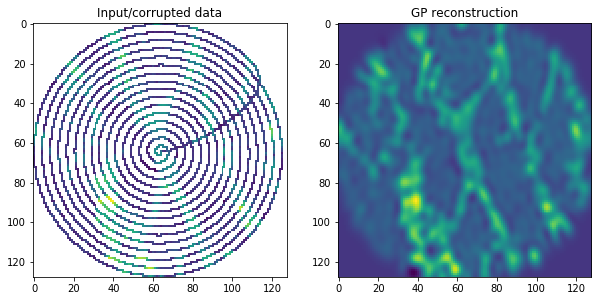

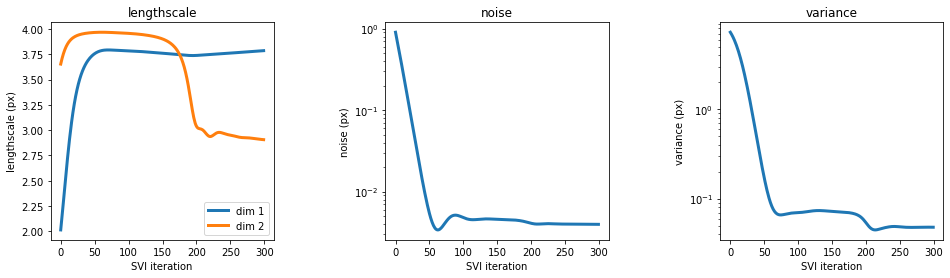

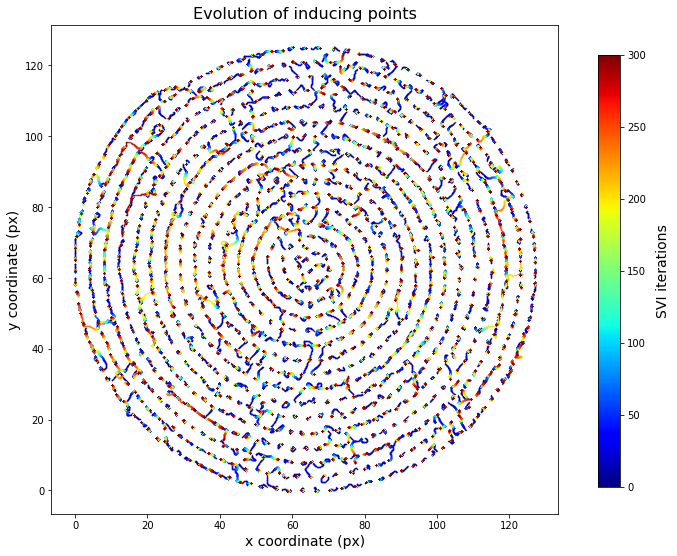

In [5]:
# type of kernel ('RBF', 'Matern52' or 'RationalQuadratic')
kernel = 'RBF'
# lengthscale constraints
lengthscale = [[1., 1.], [4., 4.]]
# Initiate and run GP reconstruction
reconstructor = gpr.reconstructor(
    X, R, X_true, kernel, lengthscale=lengthscale,
    indpoints=1000, learning_rate=0.1, iterations=300, 
    use_gpu=True, verbose=False
)
mean, sd, hyperparams = reconstructor.run()
# Plot results and evolution of kernel hyperparameters during training
gprutils.plot_reconstructed_data2d(R, mean, cmap='viridis')
gprutils.plot_kernel_hyperparams(hyperparams)
gprutils.plot_inducing_points(hyperparams)

We can also try [structured kernel](http://proceedings.mlr.press/v37/wilson15.pdf) GP approach using the GPyTorch implementation under the hood:

Model training...
average time per iteration: 0.22599999999999998 s
training completed in 36.3 s
Final parameter values:
 lengthscale: [2.7024 2.7024], noise: 0.0024733
Calculating predictive mean and uncertainty...
Batch 1/1
Done


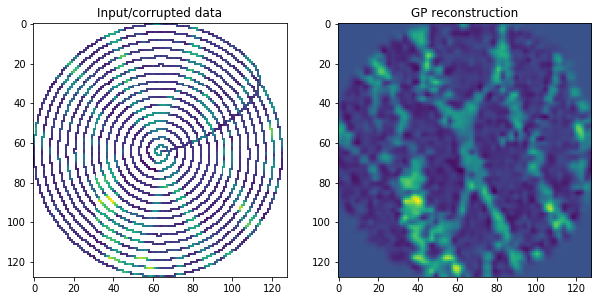

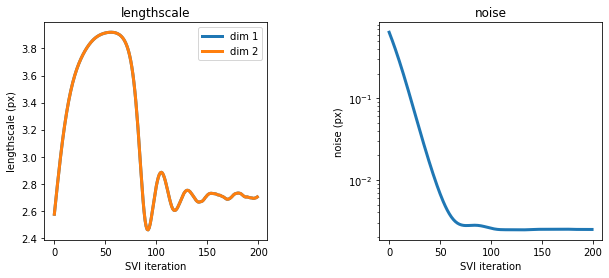

In [6]:
# Initiate and run GP reconstruction
skreconstructor = skgpr.skreconstructor(
    X, R, X_true, kernel, lengthscale=lengthscale,
    grid_points_ratio=1., learning_rate=0.1, 
    iterations=200, calculate_sd=True, num_batches=1,
    use_gpu=True, verbose=False
)
(mean, sd), hyperparams = skreconstructor.run()
# Plot results and evolution of kernel hyperparameters during training
gprutils.plot_reconstructed_data2d(R, mean, cmap='viridis')
gprutils.plot_kernel_hyperparams(hyperparams)